In [4]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, accuracy_score

# Set random seed
torch.manual_seed(10)
np.random.seed(10)
random.seed(10)

# Define transformation with augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Standard transformation for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets with appropriate transformations
train_ds = datasets.ImageFolder(root="less_data/train", transform=train_transform)
test_ds = datasets.ImageFolder(root="less_data/test", transform=test_transform)

# Data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)

class_names = train_ds.classes
print(f'Class Names: {class_names}')
print(f'Number of classes: {len(class_names)}')

# Load GoogLeNet (Inception v1) model
googlenet = models.googlenet(pretrained=True)
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, len(class_names))  # Modify the classifier

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
googlenet.to(device)
print(f'Using device: {device}')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters(), lr=0.001)

# Track training and testing accuracy
train_accuracies, test_accuracies = [], []

# Training loop
epochs = 5
for epoch in range(epochs):
    print(f'\nStart of epoch {epoch+1}/{epochs}')
    start_time = time.time()
    train_loss, train_correct = 0, 0
    test_loss, test_correct = 0, 0

    # Training phase
    googlenet.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data).item()

    train_accuracy = train_correct / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    googlenet.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = googlenet(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            test_correct += torch.sum(preds == labels.data).item()

    test_accuracy = test_correct / len(test_loader.dataset)
    test_accuracies.append(test_accuracy)
    print(f'Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')
    print(f'Epoch Duration: {time.time() - start_time:.0f} seconds')

    # Final evaluation
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = googlenet(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

report = classification_report(y_true, y_pred, labels=range(len(class_names)), target_names=class_names, digits=4)
accuracy = accuracy_score(y_true, y_pred)
print(report)
print(f'Overall accuracy: {accuracy * 100:.2f}%')

Class Names: ['baseball', 'basketball', 'beachballs', 'billiard ball', 'bowling ball', 'brass', 'buckeyballs', 'cannon ball', 'chrochet ball', 'cricket ball', 'crystal ball', 'eyeballs', 'football', 'golf ball', 'marble', 'meat ball', 'medicine ball', 'paint balls', 'pokeman balls', 'puffballs', 'rubberband ball', 'screwballs', 'sepak takraw ball', 'soccer ball', 'tennis ball', 'tether ball', 'volley ball', 'water polo ball', 'wiffle ball', 'wrecking ball']
Number of classes: 30
Using device: cpu

Start of epoch 1/5
Train Acc: 0.6570, Test Acc: 0.8533
Epoch Duration: 215 seconds

Start of epoch 2/5
Train Acc: 0.7694, Test Acc: 0.8600
Epoch Duration: 225 seconds

Start of epoch 3/5
Train Acc: 0.7975, Test Acc: 0.9200
Epoch Duration: 222 seconds

Start of epoch 4/5
Train Acc: 0.8103, Test Acc: 0.9133
Epoch Duration: 231 seconds

Start of epoch 5/5
Train Acc: 0.8420, Test Acc: 0.9400
Epoch Duration: 357 seconds
                   precision    recall  f1-score   support

         baseball 

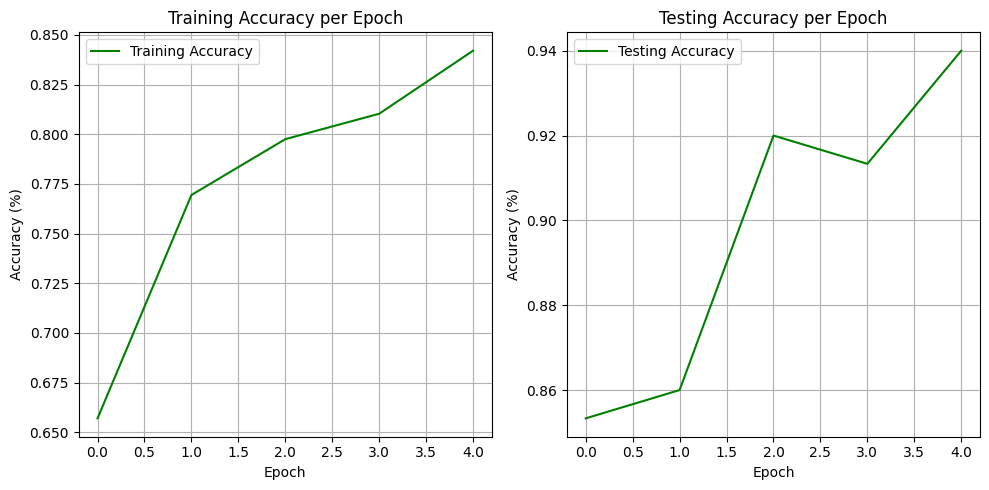

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy', color='Green')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Testing Accuracy', color='Green')
plt.title('Testing Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()